In [ ]:
import sys
sys.path.append('../core')
sys.path.append('/packing/code/core/')

import pack_runner
import pack_ga
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dill
import importlib
importlib.reload(pack_runner)

# Configuration
output_dir = '../../results/many_ga/'
os.makedirs(output_dir + 'full/', exist_ok=True)
os.makedirs(output_dir + 'abbr/', exist_ok=True)

fast_mode = True  # Set to True for quick testing
which_runner = pack_runner.baseline_runner  # Which example runner to use

In [5]:
# Get git commit ID for tracking
try:
    import git
    repo = git.Repo(search_parent_directories=True)
    git_commit_id = repo.head.object.hexsha
    print(f"Git commit: {git_commit_id[:8]}")
except:
    git_commit_id = 'no_git'
    print("Git not available, using 'no_git' as commit ID")

Git commit: 4f97d107


In [ ]:
# Main loop for running multiple GA experiments
for i in range(3):
    print(f'\n=== Starting seed {i} ===')
    
    r = which_runner(fast_mode=fast_mode)

    r.seed = i
    r.base_ga.N_trees_to_do = np.array([40])
    
    # Check if this experiment already exists
    base_filename = f"{r.label}_{r.seed}_{git_commit_id[:8]}"
    if fast_mode:
        base_filename += '_fast'
    # if len(glob.glob(output_dir + 'full/' + base_filename + '*')) >= 1:
    #     print('Skipping - already exists')
    #     continue
    
    # Run the experiment
    start_time = time.time()
    r.run()
    elapsed_time = time.time() - start_time
    
    if r.exception is not None:
        print(f"ERROR occurred: {r.exception[:200]}")
        continue
    
    # Get best costs for each N_trees
    best_costs_final = r.best_costs[-1, :]
    print(f"\nElapsed time: {elapsed_time:.1f}s")
    print(f"Best final costs: {best_costs_final}")
    print(f"Modifier values: {r.modifier_values}")
    
    # Create score string from average best cost
    avg_cost = np.mean(best_costs_final)
    score_str = f"{avg_cost:.4f}".replace('.', '_')
    
    # Save full version (with populations)
    output_file_full = output_dir + 'full/' + base_filename + '_f.pkl'
    with open(output_file_full, 'wb') as f:
        dill.dump(r, f)
    print(f"Saved full: {output_file_full}")
    
    # Save abbreviated version (without full populations to save space)
    r_abbr = copy.deepcopy(r)
    r_abbr.result_ga.populations = []  # Clear populations to save space
    output_file_abbr = output_dir + 'abbr/' + base_filename + '_a.pkl'
    with open(output_file_abbr, 'wb') as f:
        dill.dump(r_abbr, f)
    print(f"Saved abbr: {output_file_abbr}")
    
    # Plot convergence
    fig, ax = plt.subplots(figsize=(10, 6))
    for i_tree, n_trees in enumerate(r.base_ga.N_trees_to_do):
        ax.plot(r.best_costs[:, i_tree], label=f'{n_trees} trees')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Cost')
    ax.set_title(f'GA Convergence - {r.label} (seed {r.seed})')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")


=== Starting seed 0 ===
{'seed': 0, 'scale_population': 6.732655185893089, 'genetic_diversity': np.False_, 'no_jiggle': np.True_, 'bfgs_for_rough': np.True_, 'scale_rough_iterations': 0.1148748719756762, 'scale_fine_iterations': 0.8319432152802452, 'rough_steps': np.int64(0), 'fine_steps': np.int64(2)}


Found 3 result files

Successfully completed runs: 3
Best average cost: 0.158141
Worst average cost: 0.214638
Mean average cost: 0.179058
Std average cost: 0.025288


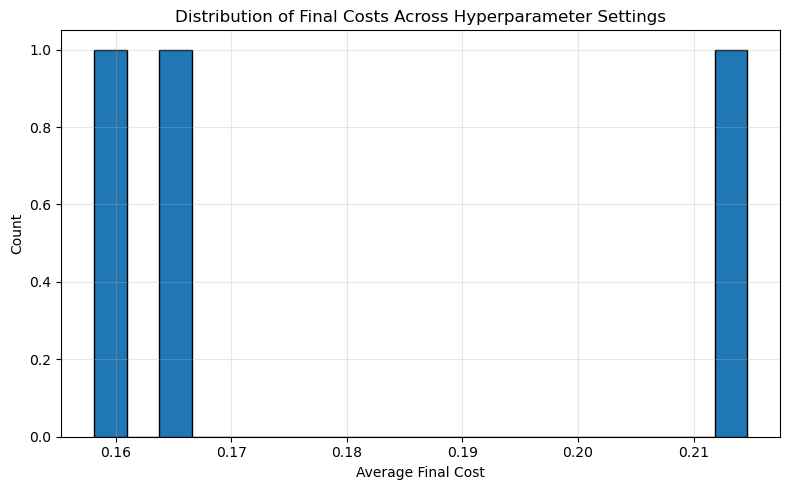

In [ ]:
# Optional: Load and analyze results
results_files = sorted(glob.glob(output_dir + 'abbr/*.pkl'))
print(f"Found {len(results_files)} result files")

if len(results_files) > 0:
    # Load all results
    results = []
    for f in results_files:
        with open(f, 'rb') as fp:
            results.append(dill.load(fp))
    
    # Extract hyperparameters and final costs
    hyperparams = []
    final_costs = []
    
    for r in results:
        if r.exception is None and r.best_costs is not None:
            hyperparams.append(r.modifier_values)
            final_costs.append(np.mean(r.best_costs[-1, :]))  # Average across N_trees
    
    print(f"\nSuccessfully completed runs: {len(final_costs)}")
    if len(final_costs) > 0:
        print(f"Best average cost: {np.min(final_costs):.6f}")
        print(f"Worst average cost: {np.max(final_costs):.6f}")
        print(f"Mean average cost: {np.mean(final_costs):.6f}")
        print(f"Std average cost: {np.std(final_costs):.6f}")
        
        # Plot distribution of final costs
        plt.figure(figsize=(8, 5))
        plt.hist(final_costs, bins=20, edgecolor='black')
        plt.xlabel('Average Final Cost')
        plt.ylabel('Count')
        plt.title('Distribution of Final Costs Across Hyperparameter Settings')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()